In [1]:
import xpress as xp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyreadr import read_r
from scipy.interpolate import interp1d
from param_watervalues import Reservoir
from time import time

In [2]:
%load_ext line_profiler

In [3]:
%matplotlib widget

In [4]:
xp.controls.outputlog = -1

In [5]:
study_path = "D:/Users/gerbauxjul/Documents/6-Etudes Antares/ERAA_scandinavie"
output_path = study_path+"/user/fast_fi00"

In [6]:
def retrieve_problem(year,week,output_path,itr=1):
    model = xp.problem()
    model.read(output_path+f"/problem-{year}-{week}--optim-nb-{itr}.mps")
    return(model)

In [22]:
S = 52
NTrain = 1
H = 168

In [8]:
def create_weekly_problem(k,s,pen_low,pen_high,output_path,reservoir):
    model = retrieve_problem(k+1,s+1,output_path)
    model.controls.xslp_log = -1

    # STATE
    x_s = xp.var("x_s",lb = 0, ub = reservoir.capacity)
    model.addVariable (x_s)          # State at the begining of the current week

    x_s_1 = xp.var("x_s_1",lb = 0, ub = reservoir.capacity)
    model.addVariable (x_s_1) # State at the begining of the following week

    q = [xp.var(f"q_{i}",lb = float('-inf'), ub =  float('inf')) for i in range(H+1)]
    model.addVariable (q)               # Level of stock at each hour

    # CONTROLS
    # Battery (<0 : pompage)
    r = [xp.var(f"r_{i}",lb = -reservoir.P_pump[7*s]*reservoir.efficiency, ub =  reservoir.P_turb[7*s]) for i in range(H)]

    model.addVariable (r)           # Charge and discharge control for the battery: r<0 means charge 
    R = xp.var()
    model.addVariable(R)                         

    z = xp.var("z",lb = float('-inf'), ub =  float('inf'))

    model.addVariable (z) # Auxiliar variable to introduce the piecewise representation of the future cost
    y = xp.var("y")

    model.addVariable (y)    # Penality for violating guide curves


    # Battery dynamics
    model.addConstraint(q[0] == x_s)                           # State of the current week equal to the initial stock of the reservoir for the week
    model.addConstraint(q[H] == x_s_1)                          # State of the following week equal to the resulting level of stock for begining of the following week

    for h in range(H):
        model.addConstraint(q[h+1] == q[h] - r[h] + reservoir.inflow[s,k])               # Stock evolution equation
    model.addConstraint(R == xp.Sum([r[h] for h in range(H)]))
    
    model.addConstraint(y >=  -pen_low* (x_s_1 - reservoir.Xmin[s]))
    model.addConstraint(y >=  pen_high* (x_s_1 - reservoir.Xmax[s]))

    cst = model.getConstraint()
    binding_id = [i for i in range(len(cst)) if "WeeklyWaterAmount" in cst[i].name]

    model.chgmcoef(binding_id,[R],[-1])
    model.chgrhs(binding_id,[0])

    model.chgobj([y,z], [1,1])
    return([model,z,x_s,x_s_1])
    

In [13]:
def modify_weekly_problem(model,z,x_s,x_s_1,V,x0,s):
    # Future cost: piecewise representation of the future cost
    nb_cons = model.attributes.rows
    if s <= S-2:
        idx = s+1
    else :
        idx = s+1
    for i in range(len(V)):
        model.addConstraint(z >= V[i][idx, 0] * x_s_1 + V[i][idx, 1])

    cst_initial_level = x_s == x0
    model.addConstraint(cst_initial_level)
    model.lpoptimize()

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(cst_initial_level)
        xf = model.getSolution(x_s_1)
        z = model.getSolution(z)
        model.delConstraint(range(nb_cons,model.attributes.rows))
        return(beta,lamb,xf,z,model.attributes.SIMPLEXITER)
    else :
        raise(ValueError)

In [14]:
def first_weekly_problem(model,z,x_s,x_s_1,x0, xf, Vj,V,s):
    nb_cons = model.attributes.rows
    model.addConstraint(z >= Vj[0] * x_s_1 + Vj[1])
    for i in range(len(V)):
        model.addConstraint(z >= V[i][s+1, 0] * x_s_1 + V[i][s+1, 1])

    # model.addConstraint(x_s_1==xf)

    cst_initial_level = x_s == x0
    model.addConstraint(cst_initial_level)
    model.lpoptimize()

    

    if model.attributes.lpstatus==1:
        beta = model.getObjVal()
        lamb = model.getDual(cst_initial_level)
        model.delConstraint(range(nb_cons,model.attributes.rows))
        return(beta,lamb,model.attributes.SIMPLEXITER)
    else :
        raise(ValueError)

In [17]:
def SDDP(reservoir:Reservoir, output_path, pen_low, pen_high, N):
    
    list_models = []
    for s in range(S):
        m = create_weekly_problem(k=0,s=s,pen_low=pen_low,pen_high=pen_high,output_path=output_path,reservoir=reservoir)
        list_models.append(m)
    
    initial_x = [reservoir.initial_level]
    for s in range(S):
        xf = initial_x[-1] + max(reservoir.inflow[s,0]*H-reservoir.P_turb[7*s]*H,0)
        initial_x.append(xf)

    Vj = np.zeros((S+1,2))
    for s in range(S-1,-1,-1):
        print(s,end="\r")
        m = list_models[s]
        beta,lamb,itr = first_weekly_problem(model=m[0],z=m[1],x_s=m[2],x_s_1=m[3],x0=initial_x[s], xf=initial_x[s+1], Vj=Vj[s+1],V=[],s=s)
        Vj[s,0] = lamb
        Vj[s,1] = beta - lamb*initial_x[s]
    V = [Vj]

    gap = 1e3+1
    while gap>=1e-4:
        x0 = reservoir.initial_level
        Vj = np.zeros((S+1,2))
        upper_bound = 0
        initial_x = [reservoir.initial_level]
        for s in range(S):
            print(s,end="\r")
            m = list_models[s]
            beta,lamb,xf,z,itr = modify_weekly_problem(model=m[0],z=m[1],x_s=m[2],x_s_1=m[3],V=V,x0=x0,s=s)
            x0 = xf
            upper_bound += beta - z
            initial_x.append(x0)
            
        for s in range(S-1,-1,-1):
            print(s,end="\r")
            m = list_models[s]
            beta,lamb,itr = first_weekly_problem(model=m[0],z=m[1],x_s=m[2],x_s_1=m[3],x0=initial_x[s], xf=initial_x[s+1], Vj=Vj[s+1],V=V,s=s)
            Vj[s,0] = lamb
            Vj[s,1] = beta - lamb*initial_x[s]    
            
        V.append(Vj)
        lower_bound = max([V[i][0,0]*reservoir.initial_level+V[i][0,1] for i in range(len(V))])
        gap = upper_bound-lower_bound
        print(gap, upper_bound, lower_bound)
        gap = gap/lower_bound
    return (V)

In [18]:
pen_low = 10000
pen_high = 0

In [19]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir")

In [23]:
vb = SDDP(reservoir, study_path+"/user/fast_fi00", pen_low, pen_high, 20) # 4m4s

294083927.3428416 4200742990.8475313 3906659063.5046897
228025176.9698143 4135715816.1894255 3907690639.219611
18892063.13418913 4002328680.541647 3983436617.407458
19879159.98696804 4003316088.410207 3983436928.4232388
5690399.481472015 3989127497.2609572 3983437097.779485
366088.88218688965 3983803405.465734 3983437316.583547


In [15]:
reservoir = Reservoir(5530000,1,study_path,"fi00","reservoir",True)

In [16]:
vb = SDDP(reservoir, study_path+"/user/fast_fi00", pen_low, pen_high, 20)

0.49259519577026367 536900041.5013402 536900041.008745


In [54]:
xNsteps = 20
X = np.linspace(0, reservoir.capacity, num = xNsteps)

In [55]:
penalties = np.zeros((xNsteps, S+1))
for s in range(S+1):
    pen = interp1d([0,reservoir.Xmin[s],reservoir.Xmax[s],reservoir.capacity],[-pen_low*(reservoir.Xmin[s]),0,0,-pen_high*(reservoir.capacity-reservoir.Xmax[s])])
    for i in range(xNsteps):
        penalties[i,s] = pen(X[i])

In [66]:
s = 1

In [67]:
[vb[i][s,:] for i in range(len(vb))]

[array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09]),
 array([0.00000000e+00, 3.80274747e+09])]

In [68]:
# i = np.argmax([X>=reservoir.Xmin[s]])
# j = np.argmin([X<=reservoir.Xmax[s]])
i = 0
j = xNsteps

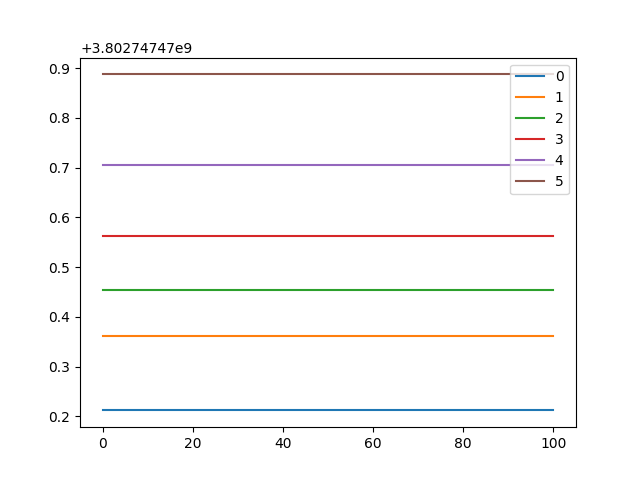

In [69]:
plt.figure()
for k in range(len(vb)):
    V = vb[k][s,0]*X+vb[k][s,1]
    plt.plot(X[i:j]/reservoir.capacity*100,V[i:j],label=f"{k}")#-penalties[i:j,s]
plt.legend()